In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor


## Register dataset

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
# for d in ["train", "val"]:
for d in ["train", "test"]:
    register_coco_instances("ucb_gait_{}".format(d), {}, 
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_{}_ucb_gait.json".format(d),
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images")
                            # "/home/josmar/proyectos/codes/datasets/lvis/lvis_v1_{}_cocofied.json".format(d),
                            # "/home/josmar/proyectos/codes/datasets/coco/train2017")

                            # "/home/josmar/proyectos/codes/datasets/ochumans/ochuman_coco_format_{}_range_0.00_1.00.json".format(d),
                            # "/home/josmar/proyectos/codes/datasets/ochumans/images")
    MetadataCatalog.get("ucb_gait_" + d).set(thing_classes=["person"])
ucb_gait_metadata = MetadataCatalog.get("ucb_gait_train")
print(ucb_gait_metadata)

Metadata(evaluator_type='coco', image_root='/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images', json_file='/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_train_ucb_gait.json', name='ucb_gait_train', thing_classes=['person'])


In [3]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("ucb_gait_train")


/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_room_039-252_040-107.jpg


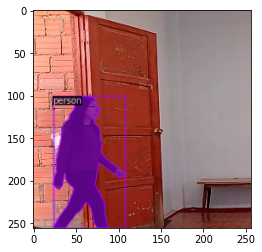

/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_030-137.jpg


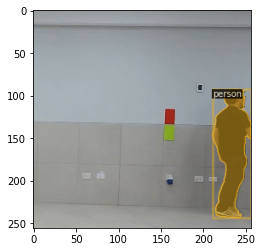

/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_019-004.jpg


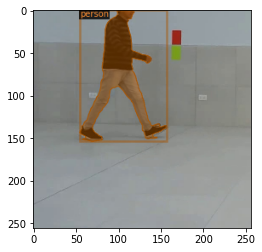

In [4]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ucb_gait_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.imshow(vis.get_image())
    plt.show()

### Alternative training

In [12]:
def beep(duration, freq):
    os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

In [5]:

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks


In [2]:
import sys
sys.path.append('/home/josmar/proyectos/centermask2')

from detectron2.engine import DefaultTrainer
from centermask.config import get_cfg
from detectron2.engine import  default_setup
from train_net import Trainer
import torch

cfg = get_cfg()
cfg.merge_from_file("/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_19_eSE_FPN_ms_4x.yaml")
cfg.DATASETS.TRAIN = ("ucb_gait_train",)

cfg.DATASETS.TEST = ("ucb_gait_val",)  # no metrics implemented for this dataset
cfg.TEST.EVAL_PERIOD = 400

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/home/josmar/proyectos/centermask2/weights/centermask2-lite-V-19-eSE-FPN-ms-4x.pth"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 6000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.FCOS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.FCOS.NUM_CLASSES = 1  # only has one class (ballon)

cfg.OUTPUT_DIR = "./output/run11_centermask2_2nd_method"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
beep(1,440)

Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_19_eSE_FPN_ms_4x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


NameError: name 'MyTrainer' is not defined

## Training

In [4]:
import sys
sys.path.append('/home/josmar/proyectos/centermask2')

from detectron2.engine import DefaultTrainer
from centermask.config import get_cfg
from detectron2.engine import  default_setup
from train_net import Trainer
import torch

cfg = get_cfg()
cfg.merge_from_file("/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_19_eSE_FPN_ms_4x.yaml")
cfg.DATASETS.TRAIN = ("ucb_gait_train",)

cfg.DATASETS.TEST = ("ucb_gait_train",)  # no metrics implemented for this dataset
cfg.TEST.EVAL_PERIOD = 100

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/home/josmar/proyectos/centermask2/weights/centermask2-lite-V-19-eSE-FPN-ms-4x.pth"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.FCOS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.FCOS.NUM_CLASSES = 1  # only has one class (ballon)



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_19_eSE_FPN_ms_4x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/26 13:35:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d

In [6]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir="/home/josmar/proyectos/codes/02_detectron2_notebooks/P3_centermask_silhouettes/output"

## Prediction

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/home/josmar/proyectos/codes/02_detectron2_notebooks/P4_centermask_sil_val/output/run11_centermask2_2nd_method/model_final.pth")
cfg.MODEL.FCOS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.FCOS.INFERENCE_TH_TEST = 0.7
cfg.DATASETS.TEST = ("ucb_gait_test", )
predictor = DefaultPredictor(cfg)

[11/26 13:36:18 d2.data.datasets.coco]: Loading /home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_test_ucb_gait.json takes 1.44 seconds.
[11/26 13:36:18 d2.data.datasets.coco]: Loaded 2175 images in COCO format from /home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_test_ucb_gait.json


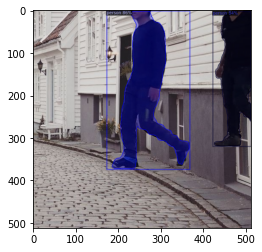

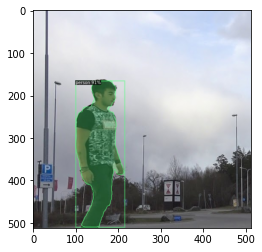

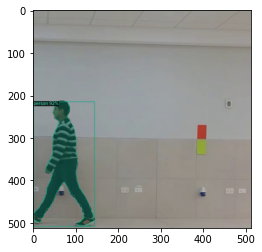

In [6]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("ucb_gait_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ucb_gait_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.imshow(out.get_image())
    plt.show()

## Evaluate

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ucb_gait_test", cfg, False, output_dir="./output/run11_centermask2_2nd_method")
val_loader = build_detection_test_loader(cfg, "ucb_gait_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [11/26 13:44:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[11/26 13:44:58 d2.data.datasets.coco]: Loading /home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_test_ucb_gait.json takes 1.25 seconds.
[11/26 13:44:58 d2.data.datasets.coco]: Loaded 2175 images in COCO format from /home/josmar/proyectos/codes/datasets/ucb_gait_cropped/cropped_test_ucb_gait.json
[11/26 13:44:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(600, 600), max_size=1000, sample_style='choice')]
[11/26 13:44:58 d2.data.common]: Serializing 2175 elements to byte tensors and concatenating them all ...
[11/26 13:44:58 d2.data.common]: Serialized dataset takes 54.28 MiB
[11/26 13:44:58 d2.evaluation.evaluator]: Start inference on 2175 images
[11/26 13:44:59 d2.evaluation.evaluator]: Inference done 11/2175. 0.0245 s / img. ETA=0:00:54
[11/26 13:45

OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan}),
             ('segm',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan})])

In [15]:
%reload_ext tensorboard
%tensorboard --logdir="/home/josmar/proyectos/codes/02_detectron2_notebooks/P4_centermask_sil_val/output" --port=6006